Importing the necessary libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

Reading the data to a pandas dataframe

In [11]:
df=pd.read_csv('/content/drive/MyDrive/Datasets/BangaloreHousePrice/Train.csv', parse_dates=['availability'])

Checking the number of nulls within a column to decide whether to drop them or use data engineering to derive values.

In [12]:
df.isnull().sum()

area_type          0
availability       0
location           1
size              16
society         5502
total_sqft         0
bath              73
balcony          609
price              0
dtype: int64

Making the availability column more readable i.e. if the flat is available anytime in march just extracting march from the column to help us have distinct labels.

In [13]:
def alter_availability(empty_list, string_compile, df):
  for f in df['availability']:
    empty_list.append(str(string_compile.findall(f))[-5:-2:])
  df['availability_month']=availability
  df['availability_month'].replace(r'^\s*$', np.NaN, regex=True,inplace=True)
  df['availability_month'].fillna(df['availability'],inplace=True)

availability=[]
a = re.compile(r'\d{2}\-\w{3}')
alter_availability(availability, a, df)

Converting the total_sqft column into a numeric data column.

In [14]:
def convert_sqft_to_num(x):
  tokens = x.split('-')
  if len(tokens) == 2:
      return (float(tokens[0])+float(tokens[1]))/2
  try:
      return float(x)
  except:
      return None

In [15]:
df.total_sqft = df.total_sqft.apply(convert_sqft_to_num)
df['total_sqft']=pd.to_numeric(df['total_sqft'], errors='coerce')
df.drop(df[df['location'].isnull()].index,inplace=True)

Adding the missing values for the column by aggregating on locality and society, since generally that's how layouts are developed in buildings.

In [69]:
df['balcony']=df['balcony'].fillna(df.groupby(['area_type','society','size'])['balcony'].transform('mean'))
df['balcony']=df['balcony'].fillna(df.groupby(['society','size'])['balcony'].transform('mean'))
df['balcony']=df['balcony'].fillna(df.groupby(['area_type','size'])['balcony'].transform('mean'))
df['total_sqft']=df['total_sqft'].fillna(df.groupby(['area_type','society','size'])['total_sqft'].transform('mean'))
df['total_sqft']=df['total_sqft'].fillna(df.groupby(['society','size'])['total_sqft'].transform('mean'))
df['total_sqft']=df['total_sqft'].fillna(df.groupby(['area_type','size'])['total_sqft'].transform('mean'))
df['bath']=df['bath'].fillna(df.groupby(['area_type','society','size'])['bath'].transform('mean'))
df['bath']=df['bath'].fillna(df.groupby(['society','size'])['bath'].transform('mean'))

#dropping the remaining rows since they are very less
df.drop(df[df['bath'].isnull()].index,inplace=True)
df.drop(df[df['balcony'].isnull()].index,inplace=True)

Visualising the split of numeric columns to understand the distribution.

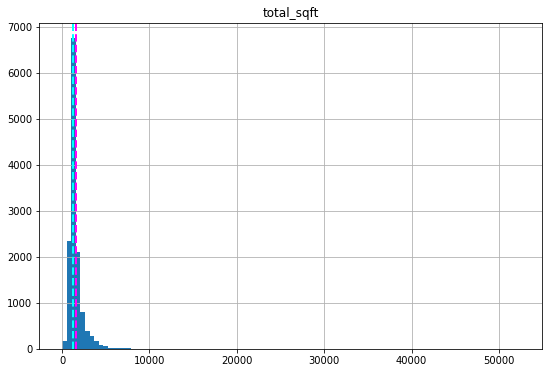

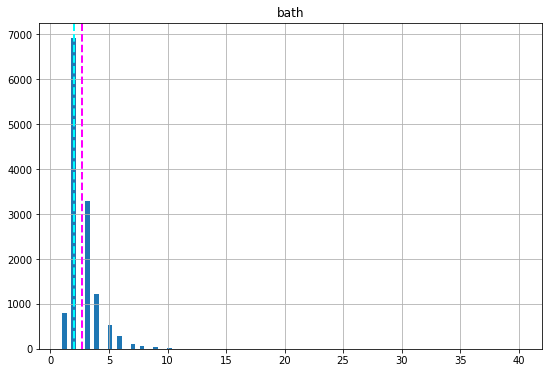

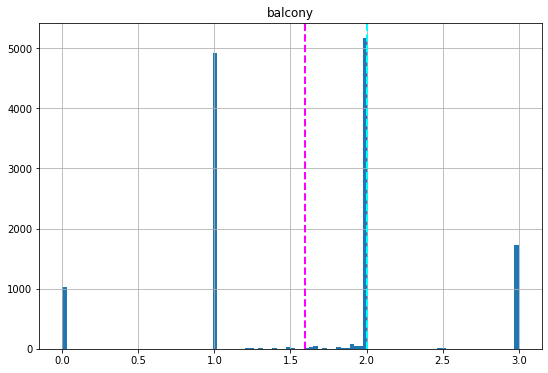

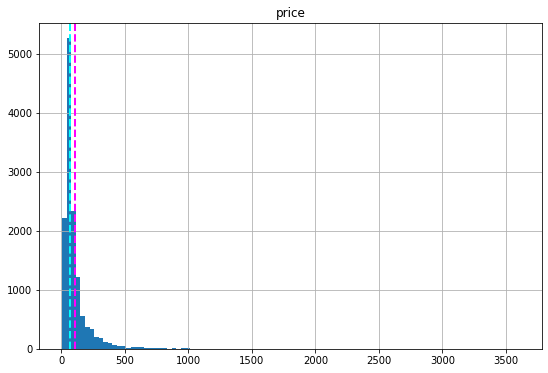

In [70]:
cols=['total_sqft', 'bath', 'balcony', 'price']
for col in cols:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    feature.hist(bins=100, ax = ax)
    ax.axvline(feature.mean(), color='magenta', linestyle='dashed', linewidth=2)
    ax.axvline(feature.median(), color='cyan', linestyle='dashed', linewidth=2)
    ax.set_title(col)
plt.show()

Plotting the categorical variables to understand the distribution of data.

---



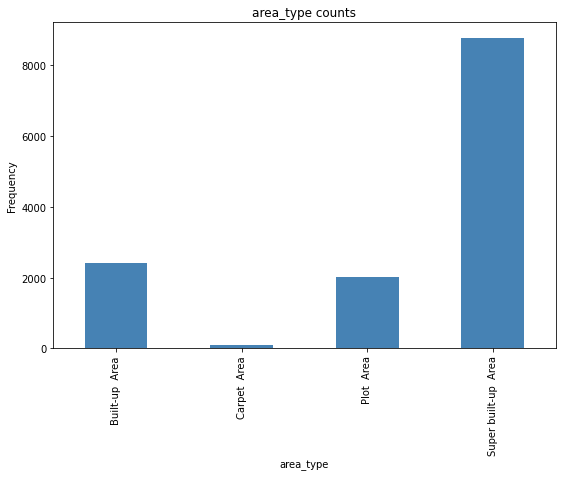

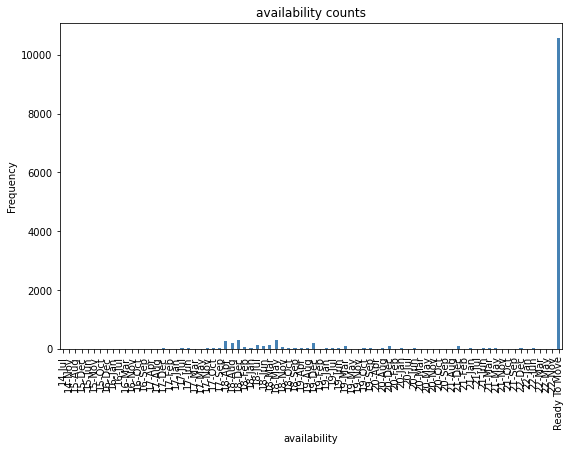

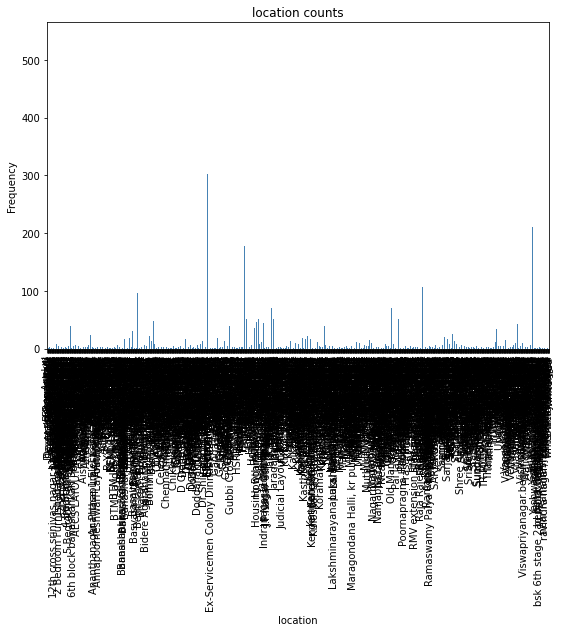

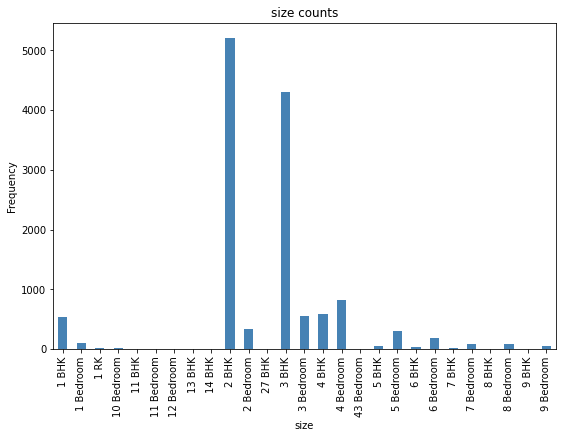

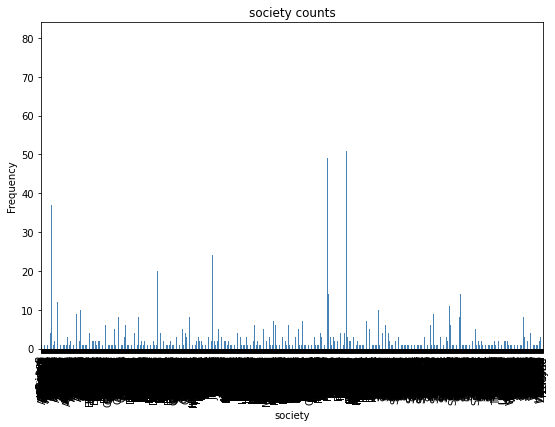

In [71]:
# plot a bar plot for each categorical feature count
categorical_features = ['area_type','availability','location','size','society']

for col in categorical_features:
    counts = df[col].value_counts().sort_index()
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    counts.plot.bar(ax = ax, color='steelblue')
    ax.set_title(col + ' counts')
    ax.set_xlabel(col) 
    ax.set_ylabel("Frequency")
plt.show()

Plotting the correlation between the numeric columns and the target dataset.

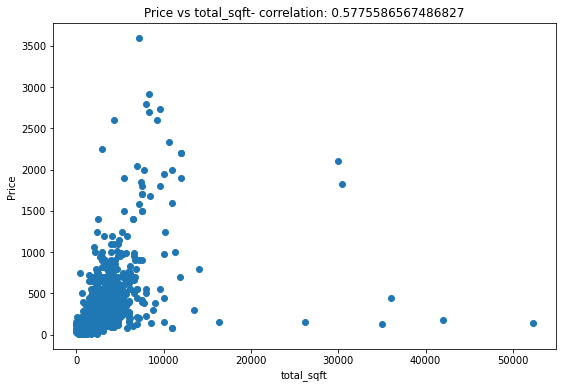

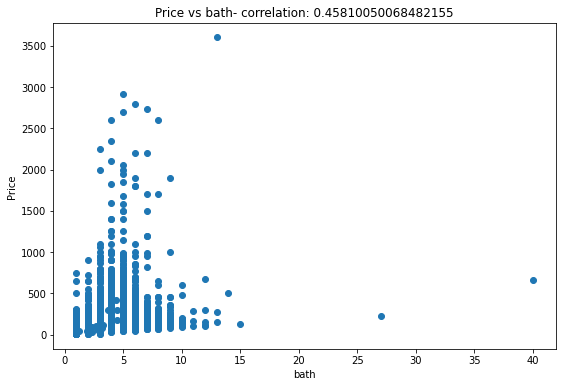

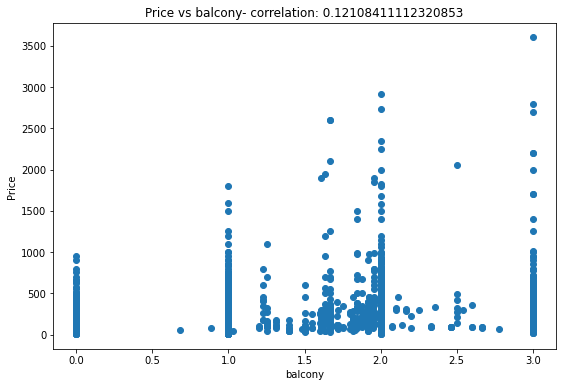

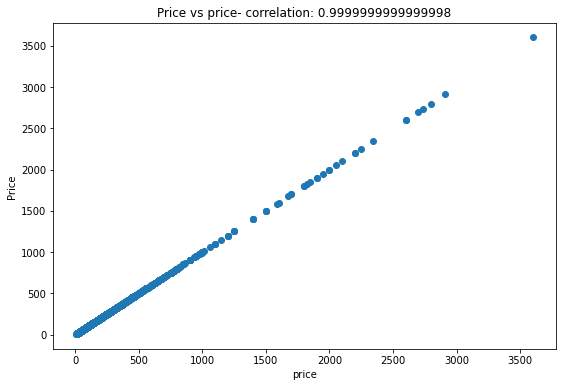

In [72]:
for col in cols:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    feature = df[col]
    label = df['price']
    correlation = feature.corr(label)
    plt.scatter(x=feature, y=label)
    plt.xlabel(col)
    plt.ylabel('Price')
    ax.set_title('Price vs ' + col + '- correlation: ' + str(correlation))
plt.show()

Visualising the distribution of categorical Variables.

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is de

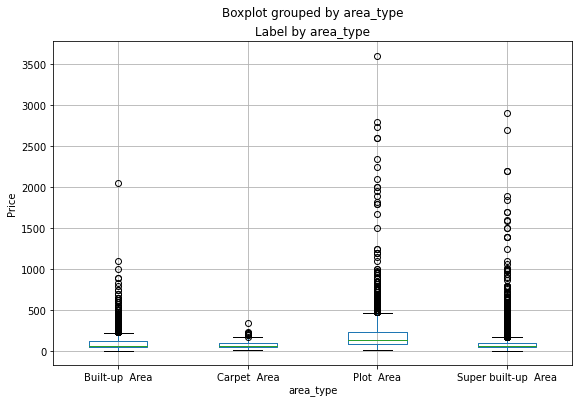

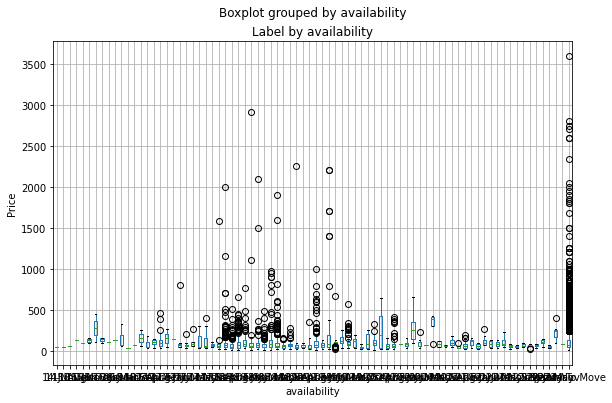

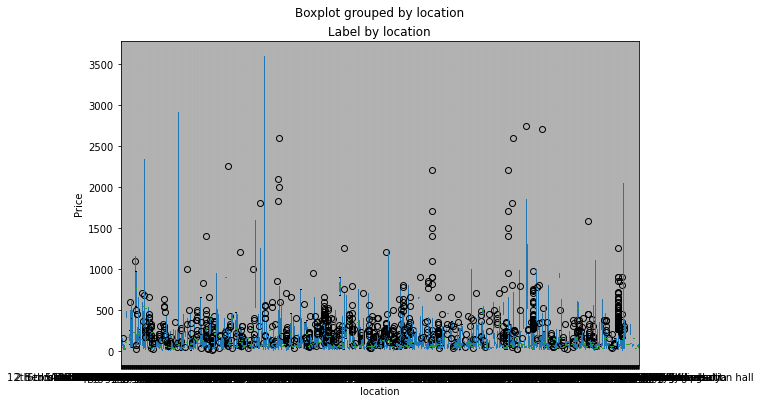

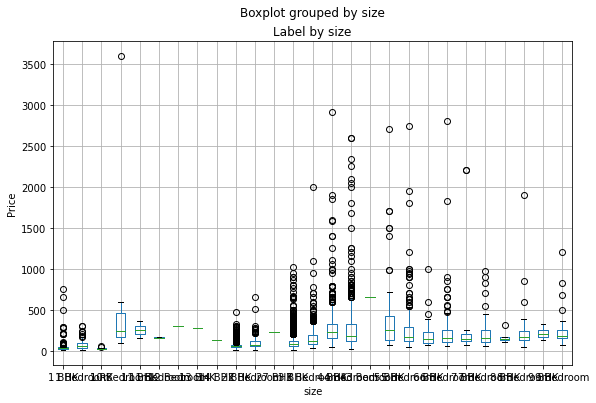

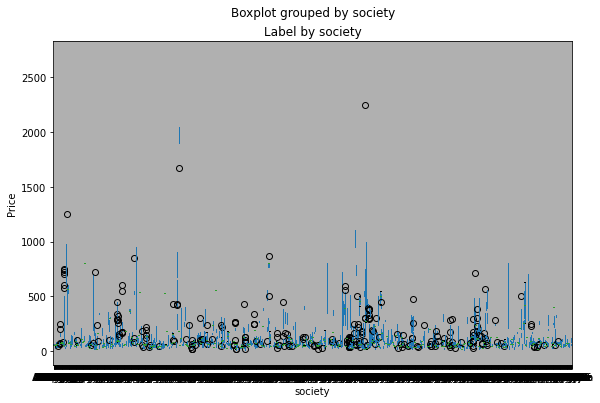

In [73]:
# plot a boxplot for the label by each categorical feature
for col in categorical_features:
    fig = plt.figure(figsize=(9, 6))
    ax = fig.gca()
    df.boxplot(column = 'price', by = col, ax = ax)
    ax.set_title('Label by ' + col)
    ax.set_ylabel("Price")
plt.show()

Creating a new column by amalgamating the society and Locaton to make a hybrid non null column.

In [74]:
#using amalmagamted column to counter for missing society names
df['society']=df['society'].fillna('')
df['area_and_society']=df['area_type']+' '+df['society']

Encoding the Categorical columns to convert them to numeric values.

In [75]:
encoder=LabelEncoder()
df['availability_encoded']=encoder.fit_transform(df['availability_month'].astype('str'))
df['size_encoded']=encoder.fit_transform(df['size'].astype('str'))
df['area_type_encoded']=encoder.fit_transform(df['area_type'].astype('str'))
# df['availability_month']

Selecting the columns for training data.

In [76]:
df_final=df[['total_sqft', 'bath', 'balcony', 'price', 
             'availability_encoded','size_encoded', 'area_type_encoded' 
            # ,'area_and_society'
             ]]

In [77]:
X_train, X_test, y_train, y_test = train_test_split(df_final.loc[ : , df_final.columns != 'price'], 
                                                    df_final.price, test_size=0.3, random_state=123)

Declaring the model names and parameters we will be using to evaluate the best available model.

In [78]:
model_params = {
    'random_forest_regressor': {
        'model': RandomForestRegressor(),
        'params' : {
            'n_estimators': [1,5,10]
        }
    },
    'linear_regression' : {
        'model': LinearRegression(),
        'params': {
            'n_jobs': [1,2,-1]
        }
    }
}

Letting GridSearchCV decide the best model for our purpose.

In [79]:
scores = []
for model_name, mp in model_params.items():
    clf =  GridSearchCV(mp['model'], mp['params'], cv=5, return_train_score=False)
    clf.fit(df_final.loc[ : , df_final.columns != 'price'],df_final.price)
    scores.append({
        'model': model_name,
        'best_score': clf.best_score_,
        'best_params': clf.best_params_
    })
    
scored_df = pd.DataFrame(scores,columns=['model','best_score','best_params'])

In [80]:
scored_df

,model,best_score,best_params
0,random_forest_regressor,0.505923,{'n_estimators': 10}
1,linear_regression,0.336693,{'n_jobs': 1}


Using the best suitable model to train and predict our output.

In [81]:
model= RandomForestRegressor(n_estimators=10, random_state = 123)
# Train the model on training data
model.fit(X_train, y_train);

In [82]:
# Use the forest's predict method on the test data
predictions = model.predict(X_test)
# Calculate the absolute errors
errors = abs(predictions - y_test)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 38.35 degrees.


In [83]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / y_test)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 69.11 %.


Loading the Test set for final submission.

In [112]:
#Testing the model on Test data set
df_test=pd.read_csv('/content/drive/MyDrive/Datasets/BangaloreHousePrice/Test.csv')

Making the test dataset consistent with our training dataset by using the same manipulations we did on training dataset.

In [113]:
availability=[]
a = re.compile(r'\d{2}\-\w{3}')
alter_availability(availability, a, df_test)

In [127]:
df_test['total_sqft']=pd.to_numeric(df_test['total_sqft'], errors='coerce')
# df_test.drop(df_test[df_test['location'].isnull()].index,inplace=True)
df_test['balcony']=df_test['balcony'].fillna(df_test.groupby(['area_type','society','size'])['balcony'].transform('mean'))
df_test['balcony']=df_test['balcony'].fillna(df_test.groupby(['society','size'])['balcony'].transform('mean'))
df_test['balcony']=df_test['balcony'].fillna(df_test.groupby(['area_type','size'])['balcony'].transform('mean'))
df_test['balcony']=df_test['balcony'].fillna(df_test.groupby(['society'])['balcony'].transform('mean'))
df_test['total_sqft']=df_test['total_sqft'].fillna(df_test.groupby(['area_type','society','size'])['total_sqft'].transform('mean'))
df_test['total_sqft']=df_test['total_sqft'].fillna(df_test.groupby(['society','size'])['total_sqft'].transform('mean'))
df_test['total_sqft']=df_test['total_sqft'].fillna(df_test.groupby(['area_type','size'])['total_sqft'].transform('mean'))
df_test['total_sqft']=df_test['total_sqft'].fillna(df_test.groupby(['society'])['total_sqft'].transform('mean'))
df_test['bath']=df_test['bath'].fillna(df_test.groupby(['area_type','society','size'])['bath'].transform('mean'))
df_test['bath']=df_test['bath'].fillna(df_test.groupby(['society','size'])['bath'].transform('mean'))
df_test['bath']=df_test['bath'].fillna(df_test.groupby(['society'])['bath'].transform('mean'))
df_test['society']=df_test['society'].fillna(method='ffill')
df_test['size'].fillna(df_test['size'].mode()[0], inplace=True)
df_test['bath'].fillna(df_test['bath'].mode()[0], inplace=True)
df_test['balcony'].fillna(df_test['balcony'].mode()[0], inplace=True)
df_test['total_sqft'].fillna(df_test['total_sqft'].mode()[0], inplace=True)
# df_test.drop(df_test[df_test['bath'].isnull()].index,inplace=True)
# df_test.drop(df_test[df_test['balcony'].isnull()].index,inplace=True
df_test['availability_encoded']=encoder.fit_transform(df_test['availability_month'].astype('str'))
df_test['size_encoded']=encoder.fit_transform(df_test['size'].astype('str'))
df_test['area_type_encoded']=encoder.fit_transform(df_test['area_type'].astype('str'))

In [129]:
df_final_test=df_test[['total_sqft', 'bath', 'balcony', 
             'availability_encoded','size_encoded', 'area_type_encoded' 
            # ,'area_and_society'
             ]]

In [130]:
predictions = model.predict(df_final_test)

In [131]:
df_test.shape

(1480, 13)

In [137]:
final_file = df_test[['area_type', 'availability', 'location', 'size', 'society',
       'total_sqft', 'bath', 'balcony']]
final_file['price']=predictions

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [139]:
final_file.to_csv('predictions.csv')